In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import tensorflow as tf

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, utils, localizer


2024-02-14 18:43:11.473001: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 18:43:11.473066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 18:43:11.473964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-14 18:43:11.480854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-14 18:43:12.508732: W tensorflow/compiler/tf2

In [2]:
# model_ew = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240112_140537-85ahbucq/files\model_85ahbucq.hdf5')
# model_ew.save('models/ew_localizer.hdf5')


In [3]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1_v2/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

#some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:50]}

In [4]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)']

input_features_xyz = ['X (m)', 'Y (m)', 'Z (m)', 'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

ew_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)', 'Argument of Periapsis (deg)', 'Longitude (deg)', 'Altitude (m)']
#ew_input_features = ['Eccentricity', 'Longitude (deg)', 'Latitude (deg)']

ns_input_features = input_features_reduced#['Eccentricity', 'Semimajor Axis (m)',  'Inclination (deg)', 'Latitude (deg)', 'Longitude (deg)']


utils.set_random_seed(42)
# ds_gen_ew = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ew_input_features,
#                                       with_labels=True, pad_location_labels=0,
#                                       nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
#                                       train_val_split=0.8,
#                                       input_stride=2,
#                                       padding='none',
#                                       transform_features=True,
#                                       scale=True,
#                                       per_object_scaling=False,
#                                       input_history_steps=48,
#                                       node_class_multipliers={'ID':1.0,'IK':1.0,'AD':1.0,'SS':1.0},
#                                       input_future_steps=24, seed=181)

ds_gen_ns = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=ns_input_features,
                                      with_labels=True, pad_location_labels=0,
                                      nonbinary_padding=[100.0, 70.0, 49.0, 34.0, 24.0],
                                      train_val_split=0.8, input_stride=2, padding='none',
                                      transform_features=True,
                                      add_daytime_feature=True,
                                      scale=True,
                                      per_object_scaling=False,
                                      node_class_multipliers={'ID':1.3,'IK':1.0,'AD':1.0,'SS':1.0},
                                      input_history_steps=48,
                                      input_future_steps=48,
                                      seed=181,
                                      deepcopy=False,
                                      verbose=2)

=========================Creating Generator=======================
Seed: 181
nTrain: 1520 nVal: 380 (0.80)
Padding: none
Horizons: 48-48 @ stride 2
Scaling: True  
Node Class Multipliers: {'ID': 1.3, 'IK': 1.0, 'AD': 1.0, 'SS': 1.0}
Sin-Cos-Transforming features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)', 'Longitude (deg)']
Adding daytime features.
Scaling now.
Adding nb padding now.
Padding node locations in non-binary fashion ([24.0, 34.0, 49.0, 70.0, 100.0, 70.0, 49.0, 34.0, 24.0])
Fitting Labelencoders now.
Dropping 8 unused columns now.
Final input features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)', 'Latitude (deg)', 'True Anomaly (sin)', 'True Anomaly (cos)', 'Argument of Periapsis (sin)', 'Argument of Periapsis (cos)', 'Longitude (sin)', 'Longitude (cos)', 'Epoch Day (sin)', 'Epoch Day (cos)']
=========================Finished Generator=======================


In [ ]:
train_ew, val_ew = ds_gen_ew.get_datasets(512, label_features=['EW_Node_Location'], shuffle=True, stride=1)

print(train_ew.element_spec)

#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,32],[32,16]], dense_layers=[64,32], l2_reg=0.0001, mixed_dropout=0.1, lr_scheduler=[30000,0.8], seed=0)
model_ew = prediction_models.Dense_NN(val_ew, conv1d_layers=[], dense_layers=[256,128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#model_ew = prediction_models.LSTM_NN(val_ew, input_dropout=0.0, mixed_dropout=0.1, lstm_layers=[128,64], dense_layers=[32,16], l2_reg=0.0001, lr_scheduler=[], seed=1)

train_ew = train_ew.map(lambda x,y:(x,y['EW_Node_Location']))
val_ew = val_ew.map(lambda x,y:(x,y['EW_Node_Location'])) # temporary fix to allow class weights

model_ew.summary()
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=20, verbose=1, plot_hist=True, 
                    class_weight={0: 1.0, 1: 2.0}, 
                    callbacks=[])
#model_ew.model.save('models/ew_localizer.hdf5')

2024-02-10 02:00:15.300032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 02:00:15.322453: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 02:00:15.322527: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 02:00:15.324140: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 02:00:15.324221: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(655805, shape=(), dtype=int64)
(TensorSpec(shape=(None, 36, 8), dtype=tf.float64, name=None), {'EW_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 31, 32)            1568      
                                                                 
 activation (Activation)     (None, 31, 32)            0         
                                                                 
 dropout (Dropout)           (None, 31, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 64)            12352     
                                                    

2024-02-10 02:00:22.753214: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1510974720 exceeds 10% of free system memory.


Epoch 1/40


2024-02-10 02:00:26.524194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-10 02:00:27.930031: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f382401ae50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 02:00:27.930085: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-10 02:00:27.936763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707526828.033976  258650 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


641/641 [==============================] - 36s 46ms/step - loss: 26.5333 - mse: 26.5060 - mae: 1.0794 - val_loss: 19.9823 - val_mse: 19.9472 - val_mae: 0.8237
Epoch 2/40
641/641 [==============================] - 17s 25ms/step - loss: 17.4965 - mse: 17.4543 - mae: 0.7988 - val_loss: 15.6512 - val_mse: 15.6021 - val_mae: 0.6337
Epoch 3/40
641/641 [==============================] - 23s 32ms/step - loss: 15.2756 - mse: 15.2191 - mae: 0.6718 - val_loss: 14.9333 - val_mse: 14.8692 - val_mae: 0.7482
Epoch 4/40
641/641 [==============================] - 20s 30ms/step - loss: 14.5268 - mse: 14.4553 - mae: 0.6344 - val_loss: 14.1035 - val_mse: 14.0247 - val_mae: 0.5162
Epoch 5/40
641/641 [==============================] - 20s 29ms/step - loss: 13.4282 - mse: 13.3442 - mae: 0.5809 - val_loss: 13.3608 - val_mse: 13.2718 - val_mae: 0.5465
Epoch 6/40
641/641 [==============================] - 20s 29ms/step - loss: 12.9010 - mse: 12.8065 - mae: 0.5574 - val_loss: 13.7831 - val_mse: 13.6828 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


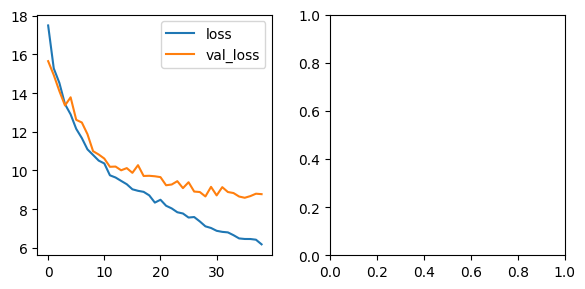

In [5]:
train_ew, val_ew = ds_gen_ew.get_datasets(1024,
                                          label_features=['EW_Node_Location_nb'],
                                          shuffle=True,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ew.element_spec)

model_ew = prediction_models.Dense_NN_regression(val_ew,
                                                 conv1d_layers=[[32,6],[64,6],[32,6]], 
                                                 dense_layers=[32,16],
                                                 l2_reg=0.0001,
                                                 mixed_dropout_dense=0.35,
                                                 mixed_dropout_cnn=0.25,
                                                 lr_scheduler=[0.003,2500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ew.summary()
# TODO: seed and dropout have a very strong impact on wether the model is able to learn at all
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=40, verbose=1, plot_hist=True, callbacks=[])


In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          with_identifier=True,
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
labels = np.stack([element for element in val_ns.map(lambda x,y,z:x).as_numpy_iterator()])
print(labels.shape)

In [ ]:
print(labels[:10,3,:])

In [ ]:
train_ns, val_ns = ds_gen_ns.get_stateful_datasets(
                                          label_features=['NS_Node_Location_nb'],
                                          stride=1)
print(train_ns.element_spec)

model_ns = prediction_models.STATEFUL_LSTM(train_ns, val_ns,
                                            dense_layers=[32,16],
                                            lstm_layers=[48,48],
                                            l2_reg=0.000,
                                            mixed_dropout_dense=0.25,
                                            mixed_dropout_lstm=0.25,
                                            lr_scheduler=[0.003,7500,0.9],
                                            seed=0)

model_ns.summary()

In [ ]:
model_ns.load_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:

hist = model_ns.fit(train_ns, val_ds=val_ns,
                    epochs=2,
                    eval_frequency=2,
                    verbose=1,
                    plot_hist=False)

In [5]:
train_ns, val_ns = ds_gen_ns.get_datasets(1024,
                                          label_features=['NS_Node_Location_nb'],
                                          shuffle=True,
                                          only_ew_sk=False,
                                          stride=1,
                                          keep_label_stride=5)
print(train_ns.element_spec)

2024-02-14 18:28:47.739805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 18:28:47.837503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 18:28:47.837602: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 18:28:47.895372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 18:28:47.895892: I external/local_xla/xla/stream_executor

Train-DS Cardinality: tf.Tensor(643901, shape=(), dtype=int64)
(TensorSpec(shape=(None, 48, 13), dtype=tf.float64, name=None), {'NS_Node_Location_nb': TensorSpec(shape=(None,), dtype=tf.float32, name=None)})


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 10)]          0         
                                                                 
 conv1d (Conv1D)             (None, 44, 32)            1632      
                                                                 
 batch_normalization (Batch  (None, 44, 32)            128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 44, 32)            0         
                                                                 
 dropout (Dropout)           (None, 44, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 32)            5152      
                                                             

2024-02-14 17:58:29.427526: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2472579840 exceeds 10% of free system memory.


Epoch 1/15


2024-02-14 17:58:34.129635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-14 17:58:35.875599: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3eb00123b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-14 17:58:35.875656: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-02-14 17:58:35.881811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1707929916.002045  150097 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-14 17:58:37.188513: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.08GiB with freed_by_count=0. The caller indica

629/629 [==============================] - 27s 29ms/step - loss: 67.8205 - mse: 67.7663 - mae: 1.9205 - val_loss: 62.4916 - val_mse: 62.4187 - val_mae: 1.5653
Epoch 2/15
629/629 [==============================] - 17s 24ms/step - loss: 57.6856 - mse: 57.5935 - mae: 1.6552 - val_loss: 55.7142 - val_mse: 55.6033 - val_mae: 1.7134
Epoch 3/15
629/629 [==============================] - 17s 25ms/step - loss: 54.0738 - mse: 53.9426 - mae: 1.5682 - val_loss: 55.4795 - val_mse: 55.3287 - val_mae: 1.5014
Epoch 4/15
629/629 [==============================] - 16s 24ms/step - loss: 51.7160 - mse: 51.5460 - mae: 1.4899 - val_loss: 50.9927 - val_mse: 50.8025 - val_mae: 1.4338
Epoch 5/15
629/629 [==============================] - 19s 28ms/step - loss: 49.6802 - mse: 49.4754 - mae: 1.4354 - val_loss: 50.3571 - val_mse: 50.1375 - val_mae: 1.6934
Epoch 6/15
629/629 [==============================] - 40s 62ms/step - loss: 48.3401 - mse: 48.1051 - mae: 1.4102 - val_loss: 49.9482 - val_mse: 49.6976 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


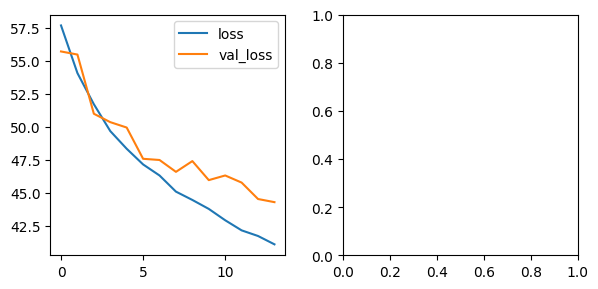

In [6]:
utils.set_random_seed(42)

model_ns = prediction_models.Dense_NN_regression(val_ns,
                                                 conv1d_layers=[[32,5],[32,5],[32,5]], 
                                                 dense_layers=[32,16],
                                                 l2_reg=0.0002,
                                                 mixed_dropout_dense=0.35,
                                                 mixed_batchnorm=True,
                                                 mixed_dropout_cnn=0.3,
                                                 lr_scheduler=[0.003,2500,0.9],
                                                 final_activation='linear',
                                                 seed=0)

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=15, verbose=1, plot_hist=True, callbacks=[])
#23 35


In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location_nb'], shuffle=True, stride=1)
model_ns = prediction_models.Dense_NN_regression(val_ns, conv1d_layers=[[32,6],[32,6]], dense_layers=[16,4],
                                                 l2_reg=0.0, mixed_dropout=0.2,
                                                 lr_scheduler=[0.002,15000,0.9],
                                                 final_activation='relu',
                                                 seed=0)
model_ns.load_model('submission/models/ns_localizer_cnn.hdf5')
model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

Starting training. Optimizing "val_accuracy"
Epoch 1/10


315/315 [==============================] - 12s 32ms/step - loss: 24.4434 - mse: 23.8070 - mae: 0.7772 - val_loss: 36.1026 - val_mse: 35.4638 - val_mae: 1.0443
Epoch 2/10
315/315 [==============================] - 12s 32ms/step - loss: 24.4961 - mse: 23.8553 - mae: 0.7763 - val_loss: 37.3393 - val_mse: 36.6965 - val_mae: 0.9797
Epoch 3/10
315/315 [==============================] - 11s 32ms/step - loss: 24.3560 - mse: 23.7110 - mae: 0.7915 - val_loss: 35.8012 - val_mse: 35.1540 - val_mae: 0.8732
Epoch 4/10
315/315 [==============================] - 11s 31ms/step - loss: 24.1906 - mse: 23.5416 - mae: 0.7616 - val_loss: 36.5763 - val_mse: 35.9255 - val_mae: 0.9893
Epoch 5/10
315/315 [==============================] - 11s 32ms/step - loss: 24.2011 - mse: 23.5478 - mae: 0.7609 - val_loss: 36.9198 - val_mse: 36.2638 - val_mae: 0.8638
Epoch 6/10
315/315 [==============================] - 11s 32ms/step - loss: 24.0239 - mse: 23.3658 - mae: 0.7651 - val_loss: 36.2868 - val_mse: 35.6269 - val_mae

/home/david/Code/splid-challenge/base/prediction_models.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


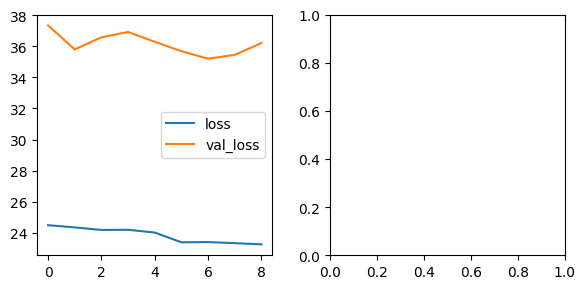

In [14]:
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=10, verbose=1, plot_hist=True, callbacks=[])

In [ ]:
hist = model_ew.fit(train_ew, val_ds=val_ew, epochs=15, verbose=1, plot_hist=True, callbacks=[])

In [13]:
model_ew.model.save('submission/models/ew_localizer_cnn.hdf5')
pickle.dump(ds_gen_ew.scaler, open('submission/models/EW_localizer_scaler_cnn.pkl', 'wb'))

/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_ns.save_weights('submission/models/ns_localizer_lstm.hdf5')

In [ ]:
print(model_ns.model.optimizer.learning_rate)

In [ ]:
train_ns, val_ns = ds_gen_ns.get_datasets(512, label_features=['NS_Node_Location'], shuffle=True, stride=1)

model_ns = prediction_models.Dense_NN(train_ns, conv1d_layers=[], dense_layers=[256, 128,64,32], l2_reg=0.0, mixed_dropout=0.0, lr_scheduler=[], seed=0)
train_ns = train_ns.map(lambda x,y:(x,y['NS_Node_Location']))
val_ns = val_ns.map(lambda x,y:(x,y['NS_Node_Location'])) # temporary fix to allow class weights

model_ns.summary()
hist = model_ns.fit(train_ns, val_ds=val_ns, epochs=20, verbose=1, plot_hist=False, class_weight={0: 0.5, 1: 20.0}, callbacks=[])
model_ns.model.save('models/ns_localizer.hdf5')

model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
model_ns.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [6]:
model_ns = tf.keras.models.load_model('/home/david/Code/splid-challenge/wandb/run-20240209_192631-m9snmqvn/files\model_m9snmqvn.hdf5')


2024-02-10 01:47:09.140770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.166275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.166358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.168938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:1c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-10 01:47:09.169030: I external/local_xla/xla/stream_executor

In [ ]:
model_ew = tf.keras.models.load_model('submission/models/ew_localizer_cnn.hdf5')

In [7]:
object_limit = None
direction = 'NS'

preds_df = localizer.create_prediction_df(ds_gen=ds_gen_ns,
                                model=model_ns,
                                train=False,
                                test=False,
                                stateful=False,
                                output_dirs=[direction],
                                object_limit=object_limit,
                                only_ew_sk=False,
                                ds_batch_size=256,
                                prediction_batches=10,
                                verbose=1)

309/309 [==============================] - 2s 5ms/step


In [8]:
subm_df = localizer.postprocess_predictions(preds_df=preds_df,
                                            dirs=[direction],
                                            threshold=60.0,
                                            add_initial_node=True,
                                            clean_consecutives=True,
                                            deepcopy=False)

evaluator, sub_df = localizer.evaluate_localizer(subm_df=subm_df,
                                                 gt_path=challenge_data_dir / 'train_labels.csv',
                                                 object_ids=list(map(int, ds_gen_ns.val_keys))[:object_limit],
                                                 dirs=[direction],
                                                 with_initial_node=False,
                                                 return_scores=False,
                                                 verbose=1)

# EW after 35 epochs:
# 50: TP: 600 FP: 19 FN: 51
# 55: TP: 596 FP: 16 FN: 55
# 60: TP: 592 FP: 11 FN: 59
# 65: TP: 589 FP: 9 FN: 62
# 70: TP: 586 FP: 8 FN: 65

# NS after 50 epochs:
# TODO: for NS, ID nodes are clearly the most difficult
# TODO: try without the ID scaling again
# 50: TP: 314 FP: 126 FN: 115
# 55: TP: 309 FP: 93 FN: 120
# 60: TP: 305 FP: 78 FN: 124
# 65: TP: 304 FP: 71 FN: 125
# 70: TP: 301 FP: 56 FN: 128

Evaluator ignoring classifications
Precision: 0.82
Recall: 0.62
F2: 0.65
RMSE: 1.026
TP: 265 FP: 60 FN: 164


In [9]:
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
for node in ['ID', 'AD', 'IK']:
    tp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'TP')])
    #fp = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FP')])
    fn = len(total_df.loc[(total_df['Node'] == node) & (total_df['classification'] == 'FN')])
    print(f"{node}: TP: {tp} FN: {fn}")

#EW:
# ID: TP: 114 FN: 42
# AD: TP: 264 FN: 13
# IK: TP: 203 FN: 15

#NS:  
# ID: TP: 112 FN: 104
# AD: TP: 0 FN: 0
# IK: TP: 185 FN: 28


ID: TP: 92 FN: 124
AD: TP: 0 FN: 0
IK: TP: 178 FN: 35


25/25 - 0s - 394ms/epoch - 16ms/step
(22,)


/home/david/Code/splid-challenge/base/localizer.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[timeindex-20:timeindex+20, 'keep'] = True
/home/david/Code/splid-challenge/base/localizer.py:144: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


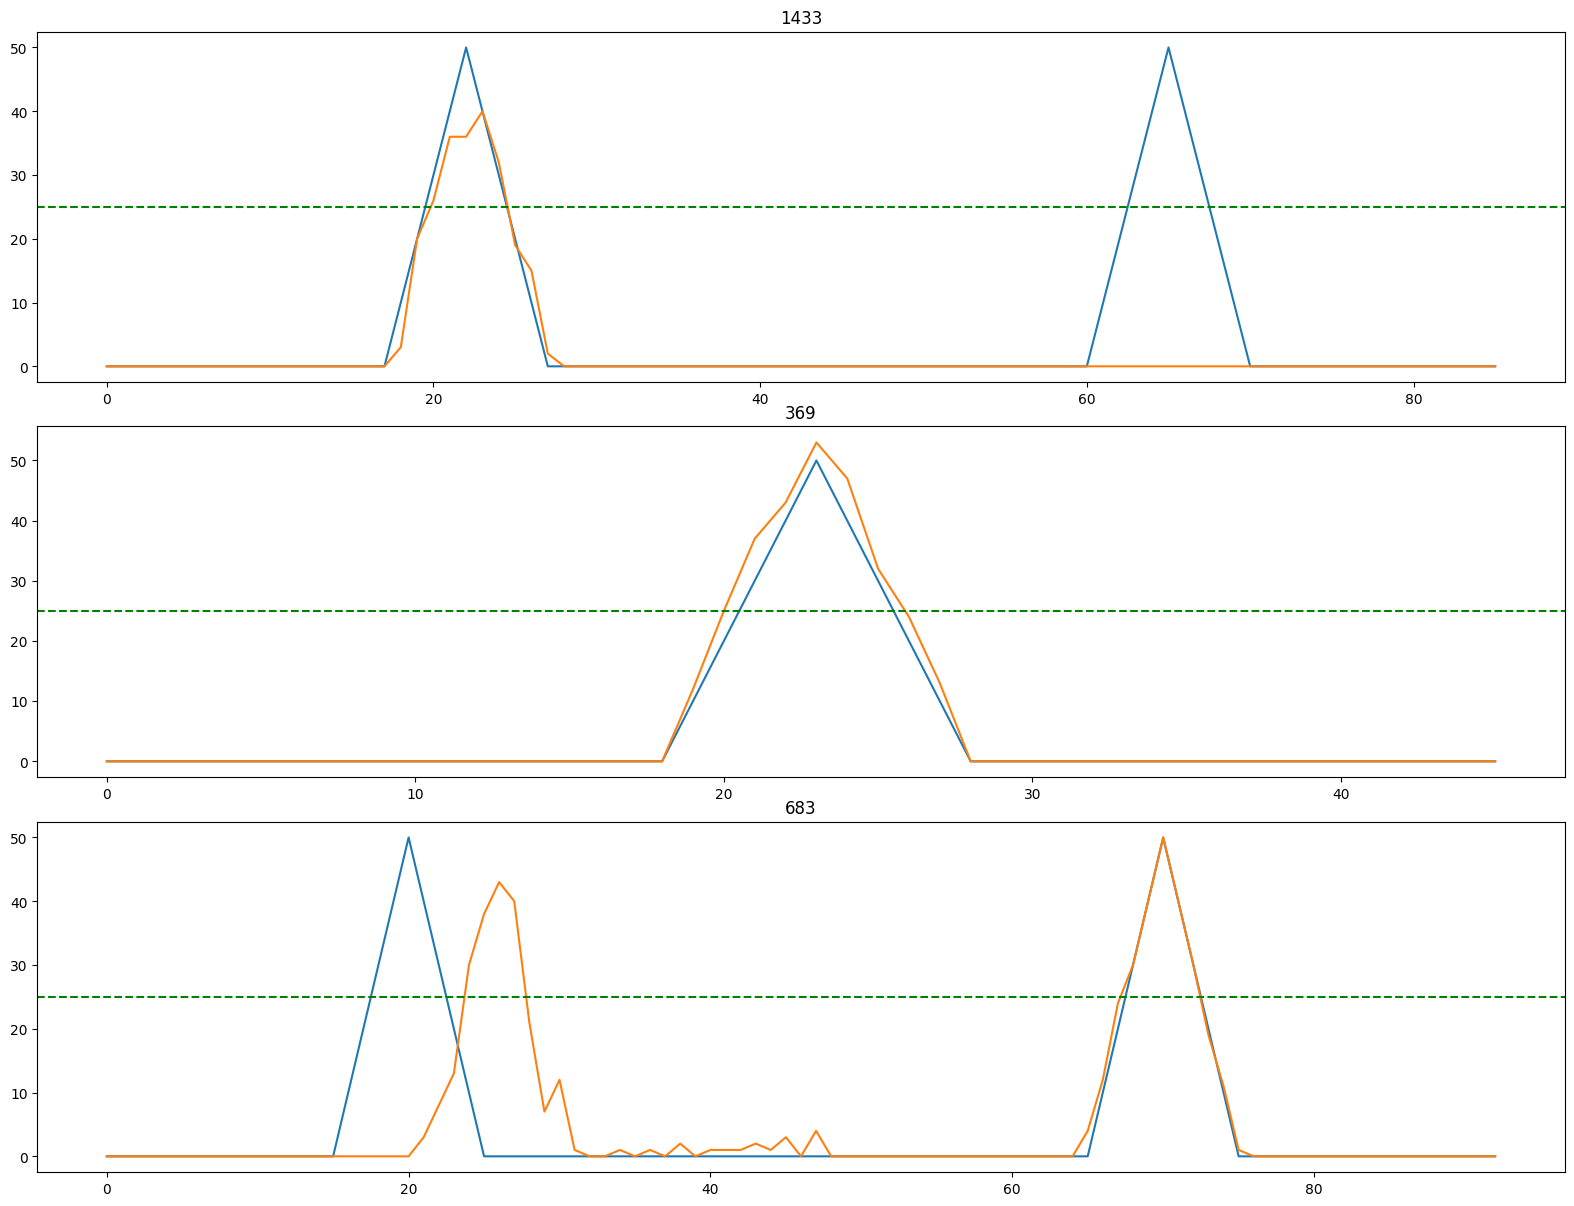

In [12]:
localizer.plot_prediction_curve(ds_gen=ds_gen_ns,
                                model=model_ns,
                                label_features=['NS_Node_Location_nb'],
                                object_ids=['683','369','1433'],#ds_gen_ns.val_keys[100:150],
                                threshold=25.0,
                                zoom=True)

In [23]:
print("as")

as
